##### Copyright 2019 The TensorFlow Authors.

# Convolutional Neural Network (CNN)

In [84]:
import cv2
import numpy as np
import pandas as pd 
import json
import glob
import os
from PIL import Image
import scipy

In [85]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut,KFold
import tensorflow_hub as hub


In [86]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import cross_val_score


In [87]:
# import images
#change user
path = "C:\\Users\\mkingsl6\\Desktop\\clean_data"
# path ='C:\\Users\\amart50\\Desktop\\CNN_test\\data'
deadlift = path + "\\Deadlift"
bench = path + "\\Bench"
squats = path + "\\Squat"

In [5]:
# normalise the pixel values
train_ = ImageDataGenerator(validation_split = .2, rescale=1./255)
TRAIN_DIR = path


train_dataset = train_.flow_from_directory(
    TRAIN_DIR,
    target_size = (224, 224),
    subset='training',
    batch_size = 10,
    class_mode='categorical'
)

validation_dataset = train_.flow_from_directory(
    TRAIN_DIR,
    target_size = (224, 224),
    subset='validation',
    class_mode='categorical',
    batch_size = 10,
)



Found 248 images belonging to 3 classes.
Found 62 images belonging to 3 classes.


In [6]:
# train_dataset.shape
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor_model = mobilenet_v2
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)


In [16]:
num_classes = 3

model = tf.keras.models.Sequential([
#   tf.keras.layers.Rescaling(1./255),
feature_extractor_layer,
# tf.keras.layers.Conv2D(16, (3,3), input_shape=(256,256,3), activation='relu'),
# tf.keras.layers.MaxPooling2D(2,2),

# tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
# tf.keras.layers.MaxPooling2D(2,2),

# tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
# tf.keras.layers.MaxPooling2D(2,2),

# tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
# tf.keras.layers.MaxPooling2D(2,2),

# tf.keras.layers.Flatten(),
# tf.keras.layers.Dense(128*4, activation='relu'),
tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [17]:
# source: https://stackoverflow.com/questions/57301698/how-to-change-a-learning-rate-for-adam-in-tf2
# to reduce lr each run
# model.fit(x_train, y_train, callbacks=[LearningRateReducerCb()], epochs=5)
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.1
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [18]:
adam = tf.keras.optimizers.Adam(
   learning_rate = 0.1, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False
)
nadam = tf.keras.optimizers.Nadam(learning_rate = 0.002, beta_1 = 0.9, beta_2 = 0.999)
sgd = tf.keras.optimizers.SGD(learning_rate = 0.01, momentum = 0.8, nesterov = False)

optimizers = [adam, nadam, sgd]
optimizer_names = ["adam", "nadam", "sgd"]

Epoch 1/3
25/25 [==============================] - 5s 164ms/step - loss: 8.2133 - accuracy: 0.6411 - val_loss: 1.3578 - val_accuracy: 0.8065
Epoch 2/3
25/25 [==============================] - 4s 143ms/step - loss: 2.5970 - accuracy: 0.8710 - val_loss: 8.2151 - val_accuracy: 0.5806
Epoch 3/3
7/7 [==============================] - 1s 107ms/step - loss: 0.1309 - accuracy: 0.9516
[0.13094794750213623, 0.9516128897666931]


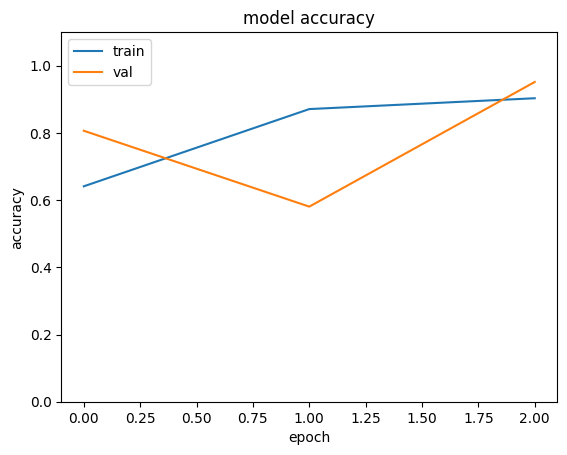

Epoch 1/3
25/25 [==============================] - 6s 174ms/step - loss: 0.1996 - accuracy: 0.9718 - val_loss: 0.1193 - val_accuracy: 0.9677
Epoch 2/3
25/25 [==============================] - 4s 145ms/step - loss: 0.1406 - accuracy: 0.9839 - val_loss: 0.1219 - val_accuracy: 0.9677
Epoch 3/3
7/7 [==============================] - 1s 111ms/step - loss: 0.1384 - accuracy: 0.9677
[0.1383558064699173, 0.9677419066429138]


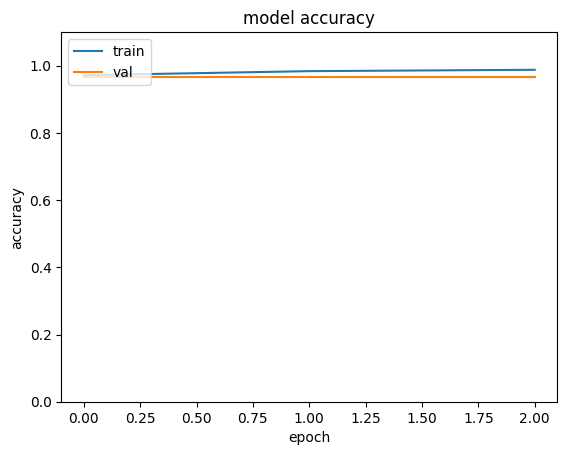

Epoch 1/3
25/25 [==============================] - 5s 171ms/step - loss: 0.0526 - accuracy: 0.9879 - val_loss: 0.1337 - val_accuracy: 0.9677
Epoch 2/3
25/25 [==============================] - 4s 144ms/step - loss: 0.0571 - accuracy: 0.9879 - val_loss: 0.1404 - val_accuracy: 0.9677
Epoch 3/3
7/7 [==============================] - 1s 106ms/step - loss: 0.1446 - accuracy: 0.9677
[0.14455996453762054, 0.9677419066429138]


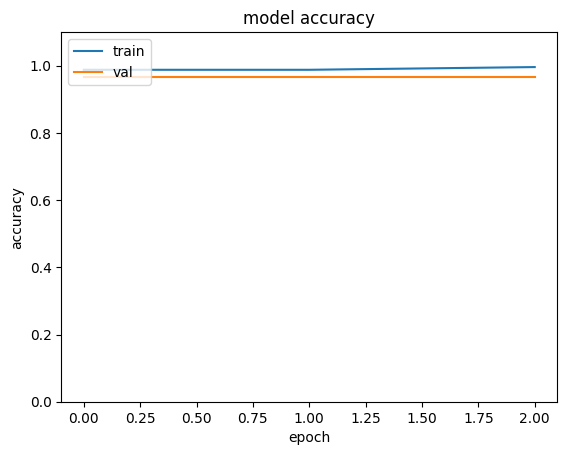

In [20]:
for i in range(len(optimizers)):
    model.compile(loss='categorical_crossentropy', optimizer=optimizers[i], metrics=['accuracy'])
    epochs=3
    history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
    )
    print( model.evaluate(validation_dataset) )

    model_save = "clean_data"+ optimizer_names[i] + ".hdf5"
    tf.keras.models.save_model(model, model_save)
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylim([0,1.1])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig("clean"+ optimizer_names[i]+".jpg", dpi = 200)
    plt.show()

In [21]:
model_trained = tf.keras.models.load_model('clean_dataadam.hdf5', 
custom_objects={'KerasLayer':hub.KerasLayer})

In [41]:
def classify_image(image, model):
    # Pre-process the image for the model
    image = cv2.imread(image)
    image = tf.image.resize(image, (224, 224))  # Resize the image
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)  # Pre-process the image for the model
    image = image[None, ...]  # Add a batch dimension to the image

    # Use the model to classify the image
    predictions = model.predict(image)

    # Return the predicted class and probability
    return tf.argmax(predictions[0]), tf.nn.softmax(predictions)[0, tf.argmax(predictions[0])]
    # , tf.nn.softmax(predictions)[0, tf.argmax(predictions[0])]

# Load the trained model
# model = tf.keras.models.load_model('model.h5')
# model = tf.keras.models.load_model('my_model.hdf5', custom_objects={'KerasLayer':hub.KerasLayer})


# class_index, class_probability = classify_image(image, model)

index_list = ["Bench", "Deadlift", "Squat"]


# Older

In [62]:
custom_path = "C:\\Users\\mkingsl6\\Desktop\\verfication_data_mike"
bench_test = custom_path + "\\Bench"
deadlift_test = custom_path + "\\Deadlift"
squats_test = custom_path + "\\Squat"

In [63]:
import glob
# bench_testlist = glob.glob(bench_test)
bench_testlist=os.listdir(bench_test)
predictions = []
# deadlift_testlist = glob.glob(deadlift_test)
deadlift_testlist=os.listdir(deadlift_test)

# squats_test = glob.glob(squats_test)
squats_testlist=os.listdir(squats_test)

In [64]:
# img = deadlift_test + "\\" + deadlift_testlist[0]
# img = bench_test + "\\" +bench_testlist[0]
img = squats_test + "\\" + squats_testlist[0]

img

'C:\\Users\\mkingsl6\\Desktop\\verfication_data_mike\\Squat\\1.jpg'

In [68]:
image = cv2.imread(img)
image = tf.image.resize(image, (224, 224))  # Resize the image
image = tf.keras.applications.mobilenet_v2.preprocess_input(image)  # Pre-process the image for the model
image = image[None, ...]  # Add a batch dimension to the image

# Use the model to classify the image
predictions = model_trained.predict(image)
predictions

1/1 [==============================] - 0s 29ms/step


array([[1.9964362e-05, 9.9998009e-01, 3.2992928e-10]], dtype=float32)

In [69]:
class_index, class_probability = classify_image(img, model_trained)

1/1 [==============================] - 0s 27ms/step


In [70]:
index_list = ["Bench", "Deadlift", "Squat"]
print(f'Predicted class: {index_list[class_index]}' )
print(f'Class probability: {class_probability:.2f}')
print(class_index.numpy())

Predicted class: Deadlift
Class probability: 0.58
1


# Brute force way 

In [76]:
class_names = ["Bench", "Deadlift", "Squats"]

In [77]:
data = []
labels = []
predictions = []

for i in bench_testlist:
    i = bench_test + "\\"+ i
    class_index, class_probability = classify_image(i, model_trained)
    predictions.append(class_index.numpy())
    labels.append(0)

for i in deadlift_testlist:
    # print(i)
    i = deadlift_test + "\\"+ i 
    # print(i)
    class_index, class_probability = classify_image(i, model_trained)
    predictions.append(class_index.numpy())
    labels.append(1)

for i in squats_testlist:
    i = squats_test + "\\"+ i 
    class_index, class_probability = classify_image(i, model_trained)
    predictions.append(class_index.numpy())
    labels.append(2)

data = np.array(data)
labels = np.array(labels)
predictions = np.array(predictions)

1/1 [==============================] - 0s 31ms/step


In [78]:
# [np.argmax( predictions[i]) for i in range(len(predictions)) ]
print(predictions)
print(labels)
print(predictions.shape)

[0 0 0 0 2 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 1 1 1 1 1 2 2 2 2 2]
(17,)


In [79]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(predictions, labels)

In [80]:
cm

array([[6, 0, 0],
       [0, 5, 5],
       [1, 0, 0]], dtype=int64)

In [82]:
disp = ConfusionMatrixDisplay(cm)

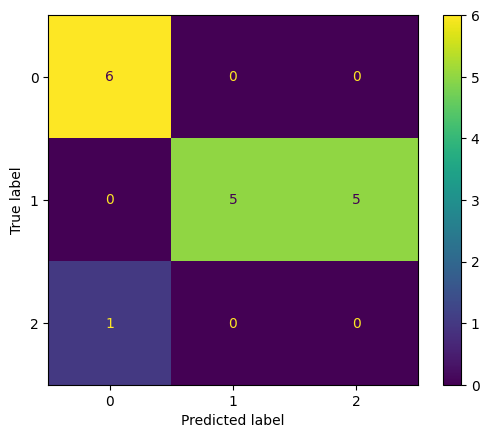

In [83]:
disp.plot()